https://medium.com/deeplearningbrasilia/should-you-use-fastai-7ce994de67d0

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.95,1.05),contrast=(0.95,1.05),saturation=(0.95,1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
!ls data/chest_xray/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
ds = {'train': datasets.ImageFolder('data/chest_xray/train/',data_transforms['train']),
      'valid': datasets.ImageFolder('data/chest_xray/val/', data_transforms['val'])}

In [5]:
dl = {'train':torch.utils.data.DataLoader(ds['train'], batch_size=16, shuffle=True, num_workers=0),
     'valid': torch.utils.data.DataLoader(ds['valid'],batch_size=16, shuffle=True,num_workers=0)}

In [6]:
dataset_sizes = {x: len(ds[x]) for x in ['train', 'valid']}

In [7]:
dataset_sizes

{'train': 5216, 'valid': 16}

In [8]:
class_name = ds['train'].classes

In [9]:
class_name

['NORMAL', 'PNEUMONIA']

In [10]:
inputs, classes = next(iter(dl['train']))

In [11]:
inputs.shape, classes.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [12]:
classes

tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [13]:
frutes = ['orange', 'apple', 'banana', 'pineapple']

In [14]:
ite = iter(frutes)

In [15]:
next(ite)

'orange'

In [16]:
while True:
    try:
        print(next(ite))
    except StopIteration:
        break

apple
banana
pineapple


In [17]:
print(ds['train'].class_to_idx)
print(ds['valid'].class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [18]:
name_idx_dict = ds['train'].class_to_idx

In [19]:
type(name_idx_dict)

dict

In [20]:
name_idx_dict['NORMAL']

0

In [21]:
index_names = [k for k,v in name_idx_dict.items() if  v==1]

In [22]:
index_names[0]

'PNEUMONIA'

In [23]:
def show_batch(dataloader,size = 8):

    inputs, classes = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    #inputs = inputs.astype('uint8')
    w,h = size, size
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 2
    ax=[]
    for i in range(1, columns*rows +1):
        ax.append(fig.add_subplot(rows, columns, i))
        index_names = [k for k,v in name_idx_dict.items() if  v==classes[i].item()]
        ax[-1].set_title('Class: '+index_names[0])
        plt.imshow((inputs[i]*255).astype(np.uint8))
    plt.show()

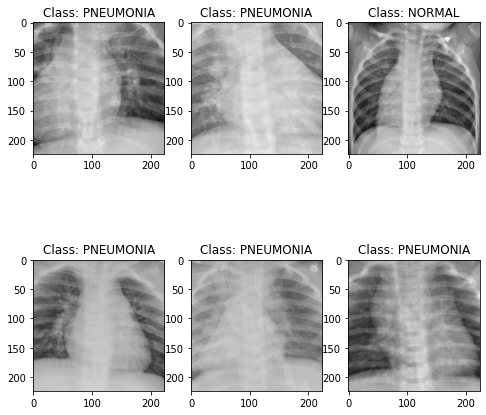

In [24]:
show_batch(dl['train'])

# 4.Creating and training a model with pure Pytorch

In [25]:
mdl = models.resnet50(pretrained=True)
mdl.fc = nn.Linear(2048,2)

In [24]:
# making sure I'm using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
device

device(type='cuda', index=0)

In [28]:
mdl = mdl.to(device)

# making sure I'm not updating the weights for the conv layers
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = False

for param in mdl.fc.parameters():
    param.requires_grad = True
    
# set loss
criterion = nn.CrossEntropyLoss()

#Training only the fully connected layer
optimizer_ft = optim.AdamW(mdl.parameters(),lr=1e-2)

mdl = mdl.to(device)

#making sure I'm not updating the weights for the conv layers
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = False

for param in mdl.fc.parameters():
    param.requires_grad=True

criterion = nn.CrossEntropyLoss()

# Training only the fully connected layer
optimizer_ft = optim.AdamW(mdl.parameters(),lr=1e-2)

In [29]:
#using cyclic LRs and MOmentuns
scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=1e-3, max_lr=1e-2, cycle_momentum=False)
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
#defining the traininng function
def fit_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('_' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects= 0
            
            #Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    #loss.requires_grad = True
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss  += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc) )
            
            #deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts =copy.deepcopy(model.state_dict())
                
        print()
        
    time_epapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_epapsed// 60, time_epapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

#defining the training function
def fit_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #loss.requires_grad = True

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
mdl_fitted = fit_model(mdl, criterion, optimizer_ft, scheduler, num_epochs=3)

Epoch 0/2
__________
train Loss: 0.2422 Acc:0.8974
valid Loss: 1.2550 Acc:0.5000

Epoch 1/2
__________
train Loss: 0.1742 Acc:0.9277
valid Loss: 0.6145 Acc:0.6250

Epoch 2/2
__________
train Loss: 0.1532 Acc:0.9410
valid Loss: 0.3253 Acc:0.8125

Training complete in 2m 36s
Best val Acc: 0.812500


In [32]:
1+1

2

# 3.Creating and training Model with fastai

In [25]:
mdl = models.resnet50(pretrained=True)
mdl.fc = nn.Linear(2048,2)

In [32]:
from fastai import *
from fastai.vision import *

In [42]:
data = DataBunch(DataLoader(ds['train'],batch_size=16,shuffle=True,num_workers=2),DataLoader(ds['valid'],batch_size=16,shuffle=True,num_workers=2))

In [43]:
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = True
    
for param in mdl.fc.parameters():
    param.requires_grad = True

In [44]:
learn = Learner(data,mdl,loss_func=nn.CrossEntropyLoss(), metrics=[metrics.accuracy],callback_fns=ShowGraph)

In [45]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [46]:
1+1

2

Failed to compute the gradients, there might not be enough points.


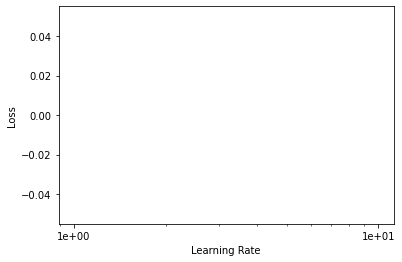

In [47]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.363726,1.071728,0.750000,01:55
1,0.196507,0.537688,0.750000,01:55
2,0.155156,0.989327,0.687500,02:03


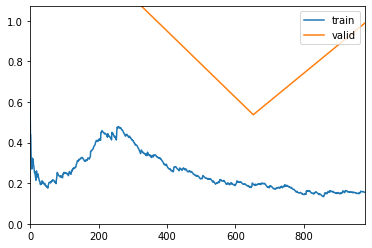

In [41]:
learn.fit_one_cycle(3,1e-3)